In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import torch
 
# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

# Función de aproximación propuesta

In [2]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)

## Utilizando un optimizador de PyTorch 

Se asume un residuo conocido para cuatro puntos de colocación.

In [3]:
def residuo(x, c):
    terms = [
        -c[0]*x**2 + c[0]*x - 2*c[0],
        -c[1]*x**3 + c[1]*x**2 - 6*c[1]*x + 2*c[1],
        -c[2]*x**4 + c[2]*x**3 - 12*c[2]*x**2 + 6*c[2]*x,
        -c[3]*x**5 + c[3]*x**4 - 20*c[3]*x**3 + 12*c[3]*x**2
    ]
    return sum(terms) + x

x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True) 
c = torch.tensor([0.01,0.01,0.01,0.01],requires_grad=True)

def loss_fn(x, c):
    y = residuo(x, c)
    loss = torch.mean(y ** 2)  # Mean squared error
    return loss

optimizer = torch.optim.Adam([c], lr=0.1)

for epoch in range(1_000):  # Number of iterations
    optimizer.zero_grad()  # Clear previous gradients
    loss = loss_fn(x, c)  # Compute loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters
    
    if epoch % 100 == 0:  # Print progress every 1000 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}, c: {c.data}')

print(f'Optimized c: {c.data}')

Epoch 0, Loss: 0.25056082010269165, c: tensor([0.1100, 0.1100, 0.1100, 0.1100])
Epoch 100, Loss: 1.0981905688822735e-05, c: tensor([ 0.1930,  0.1659,  0.0350, -0.0381])
Epoch 200, Loss: 5.340987627278082e-06, c: tensor([ 0.1909,  0.1724,  0.0222, -0.0301])
Epoch 300, Loss: 2.2232052288018167e-06, c: tensor([ 0.1900,  0.1782,  0.0106, -0.0224])
Epoch 400, Loss: 7.582827379337687e-07, c: tensor([ 0.1893,  0.1826,  0.0018, -0.0167])
Epoch 500, Loss: 2.1407150541108422e-07, c: tensor([ 0.1889,  0.1855, -0.0040, -0.0129])
Epoch 600, Loss: 5.0202100254637116e-08, c: tensor([ 0.1886,  0.1871, -0.0074, -0.0107])
Epoch 700, Loss: 9.772485043413326e-09, c: tensor([ 0.1885,  0.1880, -0.0092, -0.0096])
Epoch 800, Loss: 1.5766030703190381e-09, c: tensor([ 0.1884,  0.1884, -0.0100, -0.0090])
Epoch 900, Loss: 2.098106688386281e-10, c: tensor([ 0.1884,  0.1886, -0.0104, -0.0088])
Optimized c: tensor([ 0.1883,  0.1887, -0.0105, -0.0087])


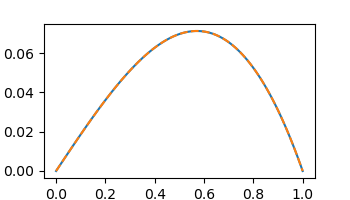

In [4]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
y_true.detach().numpy()
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

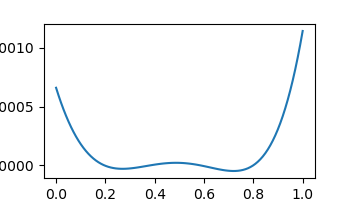

In [5]:
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,residuo(x, c).detach().numpy())
plt.show()

In [6]:
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

5.4947246e-05

## Utilizando diferenciación automática

In [33]:
def derivative(dy, x, order=1):
    for _ in range(order):
        dy = torch.autograd.grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

def loss_fn(x, c):
    y = residuo(x, c)
    return torch.mean(y ** 2)  # Error cuadrático medio

# Configuración de datos y parámetros
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True)
c = torch.tensor([0.01,0.01,0.01,0.01,0.01,0.01,0.01], requires_grad=True)

# Configuración del optimizador
optimizer = torch.optim.Adam([c], lr=0.1)

# Bucle de entrenamiento
num_epochs = 10_000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Limpiar gradientes previos
    current_loss = loss_fn(x, c)  # Calcular la pérdida
    current_loss.backward()  # Calcular gradientes
    optimizer.step()  # Actualizar parámetros

    if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
        print(f'Epoch {epoch}, Loss: {current_loss.item()}, c: {c.data}')

# Resultados optimizados
print(f'Optimized c: {c.data}') 

Epoch 0, Loss: 0.2432946264743805, c: tensor([0.1100, 0.1100, 0.1100, 0.1100, 0.1100, 0.1100, 0.1100])
Epoch 100, Loss: 6.178805051604286e-06, c: tensor([ 1.9060e-01,  1.7270e-01,  2.5756e-02, -2.6330e-02, -2.3198e-02,
        -1.0198e-04,  2.7780e-02])
Epoch 200, Loss: 1.9247675675515552e-10, c: tensor([ 0.1915,  0.1733,  0.0261, -0.0262, -0.0233, -0.0003,  0.0273])
Epoch 300, Loss: 1.0269562977782698e-14, c: tensor([ 0.1915,  0.1733,  0.0261, -0.0262, -0.0233, -0.0003,  0.0273])
Epoch 400, Loss: 1.176836406102666e-14, c: tensor([ 0.1915,  0.1733,  0.0261, -0.0262, -0.0233, -0.0003,  0.0273])
Epoch 500, Loss: 8.049116928532385e-15, c: tensor([ 0.1915,  0.1733,  0.0261, -0.0262, -0.0233, -0.0003,  0.0273])
Epoch 600, Loss: 2.220446049250313e-15, c: tensor([ 0.1915,  0.1733,  0.0261, -0.0262, -0.0233, -0.0003,  0.0273])
Epoch 700, Loss: 1.176836406102666e-14, c: tensor([ 0.1915,  0.1733,  0.0261, -0.0262, -0.0233, -0.0003,  0.0273])
Epoch 800, Loss: 5.551115123125783e-15, c: tensor([ 0.

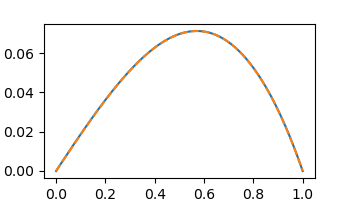

In [34]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

In [35]:
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

0.0015944967

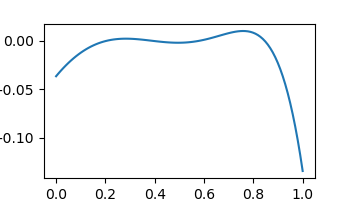

In [36]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()